# HIME: High-latitude Input for Meso-scale Electrodynamics
Author: Dogacan S. Ozturk <br>
Contact: dcsoztrk@umich.edu



Copyright (c) 2020, California Institute of Technology ("Caltech") and University of Michigan. U.S. Government sponsorship acknowledged. All rights reserved.


This notebook provides a working example for users to navigate through the HIME Framework.

In [1]:
#!/usr/bin/env python

First, the required libraries are imported. For a full list of dependencies, we refer the user to the 'Requirements.txt' distibuted with HIME. 

In [2]:
import os
import sys
from glob import glob
import tables
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
myFmt = mdates.DateFormatter('%H:%M')

After the default python libraries are installed, the HIME libraries are also imported from the Code folder.

In [3]:
sys.path.insert(0, '../Code/')
from spacepy.pybats import gitm
import hime_helper_functions
from downsample_data import downsample_pfisr_data
from merge_potentials import merge_pfisr_with_gitm_potentials

This unreleased version of SpacePy is not supported by the SpacePy team.


## 1. Downsampling Electric Field Data

For this example, we are using the 2DVEF data product from PFISR. The example file is in the Example folder. For different 2D electric field products, the user needs to provide the right path for the file.

In [4]:
filename = '../Examples/Files/PFISR_Data/20191026.002_lp_1min-fitcal_2dVEF_001001-geo600km.h5'

The user needs to provide a grid resolution for the downsampling of the electric field data. PFISR 2DVEF products have a high resolution, approximately 0.3 degree in latitude and 0.1 degree in longitude. The grid resolution provided should be the same with the grid resolution of the global potential provided.

In [5]:
gridRes = 0.75

Now we can run the downsample_pfisr_data command to obtain the PFISR potentials, electric fields and coordinate points on the downsampled grid. The grids returned are in magnetic coordinates, because PFISR data is uniform in magnetic coordinates, which simplifies the downsampling process.

In [6]:
PhiX, PhiY, Ex_downsampled, Ey_downsampled, Ex_calculated, Ey_calculated, XnewGrids, YnewGrids, experimentTimes = downsample_pfisr_data(filename, gridRes)

Let's see how these downsampled potentials look compared to the original PFISR electric field estimates.

### Electric Field Plots 

Normally, the code doesn't require the PFISR data to be read explicitly, but to make a comparison plot, we will read in the data.

In [7]:
# The PFISR file is a h5 file, which is recommended to be read by the tables library.
h5file = tables.open_file(filename)
pfisrData = h5file.get_node('/')

Next, we are allocating numpy arrays to store the electric field estimates.

In [8]:
# Read the electric field data and corresponding grids
Ex_geo = pfisrData['Fit2D']['Ex_geo'].read()
Exg = np.nan_to_num(Ex_geo)

Ey_geo = pfisrData['Fit2D']['Ey_geo'].read()
Eyg = np.nan_to_num(Ey_geo)

Ex_mag = pfisrData['Fit2D']['Ex'].read()
Exm = np.nan_to_num(Ex_mag)

Ey_mag = pfisrData['Fit2D']['Ey'].read()
Eym = np.nan_to_num(Ey_mag)

xgeo = np.nan_to_num(pfisrData['Grid']['X_geo'].read())
ygeo = np.nan_to_num(pfisrData['Grid']['Y_geo'].read())

xmag = np.nan_to_num(pfisrData['Grid']['X'].read())
ymag = np.nan_to_num(pfisrData['Grid']['Y'].read())

# Make a mesh from new grid points for plotting
yadapted, xadapted = np.meshgrid(YnewGrids, XnewGrids)

We are now ready to make comparison plots between the original grid and the adapted grid. First, the user is to define a directory to save the plots, since we can make multiple plots using the script below.

In [9]:
plotdir = './hime_comparison_plots'
if not os.path.exists(plotdir):
    os.mkdir(plotdir)

Next, we can define the plot specific parameters.

In [10]:
# Color levels
nLevels = 51
clevels = np.linspace(-50,50, nLevels)

# Define Plotting Parameters
lonMin = 258.
lonMax = 278.
latMin = 62.
latMax = 74.

For interpretation purposes, we will include the PFISR location on the plot.

In [11]:
pfisrLon = -93.5+360.
pfisrLat = 65.

The example below is simplified to show one sample plot. If the user wishes to make multiple plots, or plot a specific time instance, they can do so by commenting out nTimes and replacing it with: <br>
nTimes = len(experimentTimes) # for multiple plots<br>
i = 62 # for 62th instance<br>

We suggest commenting out the #plt.close() at the end of the for loop to prevent running out of memory.

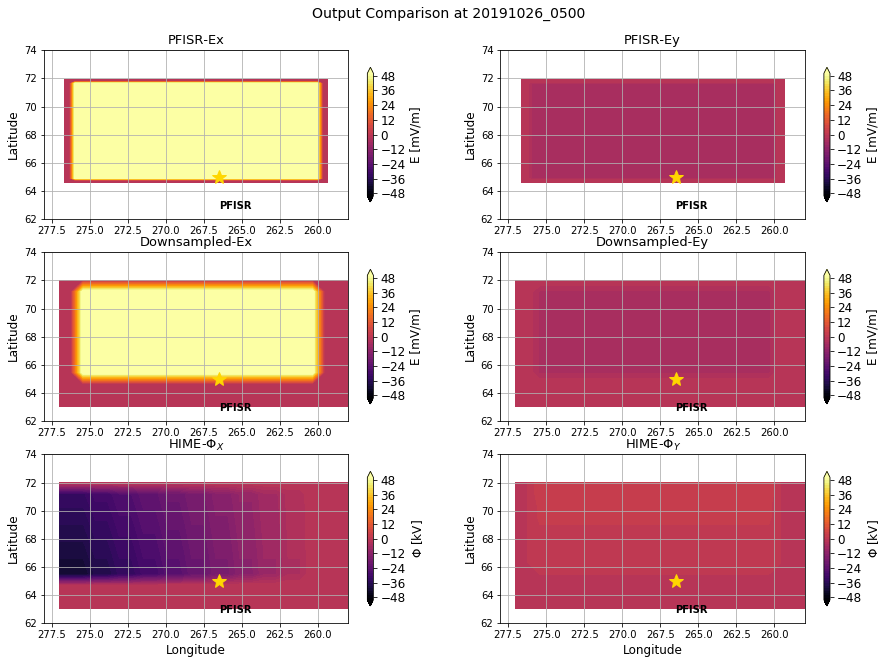

In [12]:
# Automate the process of plotting
variableTitles = ['PFISR-Ex','PFISR-Ey','Downsampled-Ex','Downsampled-Ey','HIME-$\Phi_{X}$','HIME-$\Phi_{Y}$']
nVariables = len(variableTitles)
plotVariables = {}
plotVariables = [Exm,Eym,Ex_downsampled,Ey_downsampled,PhiX/1000.,PhiY/1000.]

nTimes = 1 
# nTimes = len(experimentTimes) comment out this statement if you would like a plot of all time samples.

for i in range(nTimes):
    #i = 62 # comment out this statement and replace with the time instance value you desire to output.
    dateExperiment = experimentTimes[i] # time of the experiment
    fig = plt.figure(figsize=(15,10)) # define figure size
    
    for k in range(nVariables):
        
        Quantity = plotVariables[k][i]
        
        a1 = fig.add_subplot(3,2,k+1)
        a1.set_ylim([latMin,latMax])
        a1.set_xlim([lonMax,lonMin])
        
        if (k>=2):
            cs1 = a1.contourf(xadapted, yadapted, Quantity, clevels, cmap='inferno',  extend='both')
        else:
            cs1 = a1.contourf(xmag, ymag, Quantity, clevels, cmap='inferno',  extend='both')
            
        cbar1 = fig.colorbar(cs1,ax=a1, shrink=0.8)
        
        if (k>=4):
            cbar1.set_label('$\Phi$ [kV]', fontsize=12)
            a1.set_xlabel('Longitude', fontsize=12)
        else:
            cbar1.set_label('E [mV/m]', fontsize=12)
            
        cbar1.ax.tick_params(labelsize=12)
        
        a1.grid()
        a1.plot(pfisrLon, pfisrLat, color='gold', marker='*', markersize=15)
        a1.text(pfisrLon, pfisrLat-2.3, 'PFISR', size=10, weight='bold')
        a1.set_title(variableTitles[k], size=13)
        a1.set_ylabel('Latitude', fontsize=12)
  
    plt.suptitle('Output Comparison at {0:%Y%m%d_%H%M}'.format(dateExperiment), fontsize=14)

    plt.subplots_adjust(top=0.92)
    plt.savefig(plotdir+'/hime_comparisons_{0:%Y%m%d_%H%M}'.format(dateExperiment), bbox_inches='tight',dpi=200)
    #plt.close() # comment out this experssion if plotting multiple time instances to prevent memory errors.


As a result, the downsampled grid is larger to preserve the data at points closer to the boundary. Now, we can move on to merging these potentials with a global potential pattern.

## 2. Merging Potentials

To merge the potentials the user is required to provide a global potential pattern. These potentials can be obtained by directly simulating a Global Circulation Model, or through the CCMC. For this example, we have used the Global Ionosphere Thermosphere Model (GITM) [2] output for the Weimer Potentials [3]. Our code can work with the 3DION, 3DUSR, or 3DHME output from GITM, as long as the output files have the potential and grid values. If the output doesn't have the PotentialY, the code will not be able to produce the differential potentials in the y direction. That's why we recommend creating a dictionary item called 'PotentialY' which is a copy of the 'Potential' values, such as: <br>
gitmSimulationResults['PotentialY'] = gitmSimulationResults['Potential'] <br>
to proceed with the code. 

First, the user needs to define the path containing the simulation results.

In [13]:
weimerSimulationList = glob('../Examples/Files/Simulations/3D*.bin')
weimerSimulationList.sort()

Next, the users need to define the merging parameter. This is a scalar value of the standard deviation for the Gaussian kernel, between 0.1 to 1.0, 0.1 indicating maximum and 1.0 indicating minimum smoothing during the merging of the local and global potentials. When minimum smoothing is applied (mergeParameter = 1.0), sharp boundaries occur between the transition from global to local potentials, when maximum smoothing is applied (mergeParameter = 0.1), local potentials at the boundaries are lost. For more information on the gaussian filter you can visit: <br>
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.filters.gaussian_filter.html <br>

We recommend 0.6 as the optimum value.

In [14]:
mergeParameter = 0.6

The user can also determine if they want the output to be plotted or saved. We recommend using the saving option to prepare the output in a GCM compatible format. We recommend using the plotting option for inspecting the output. The plots can be found at "./potentials/hime_plots', and the output can be found at "./potentials/hime_output'.

In [15]:
plotPotentials = True
savePotentials = True

Now, we can use the potentials calculated on the new downsampled grids, and pass them to the merge_pfisr_with_gitm_potentials function.

In [16]:
phiXhime, phiYhime, himeEx, himeEy, xHimeMesh, yHimeMesh, himeTimes = merge_pfisr_with_gitm_potentials(PhiX, PhiY, XnewGrids, YnewGrids, experimentTimes, weimerSimulationList, gridRes, mergeParameter, plotPotentials, savePotentials)

### Merged Potential Plots

We can now have a look into what HIME actually produces as input. The plot_hime_potentials script requires the user to define a directory.

In [17]:
plotdir = './hime_comparison_plots'
if not os.path.exists(plotdir):
    os.mkdir(plotdir)

Next, let's define the parameters required for plotting.

In [18]:
# Plotting parameters
plimit = 60.
nlevels = 25
plevels = np.linspace(-plimit, plimit,nlevels)
cMapPotential = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#760797","#C2837D","#F2DCC8","#6EB0A6","#2D61A2"])

Now, we can plot the HIME potentials on the new grid. If the user employed 3DION files the potentials will have values everywhere on the grid, if 3DHME files are used, the potentials will look like a slice. The user needs to define a time step to plot. For demonstration purposes, we will pick 1.

In [19]:
ind = 1

Next, we can plot the Potential X and Potential Y side by side for the Northern Hemisphere in magnetic local time. We urge the users to practice extra caution when MLT changes from pre-midnight to post-midnight. HIME is designed to handle such variations through introducing a Median Grid. For spatially large 2D estimates, such as SuperDARN measurements, which can span more than 6 hours in local time grid, we suggest users change the xMedMeshPts varible's upper limit from 30 hours to 24+Max Local Time Extent of the data set they intend to use.

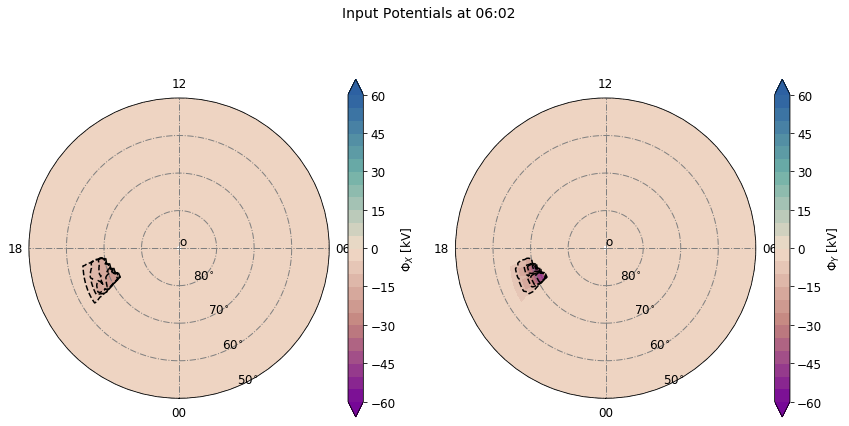

In [20]:
fig = plt.figure(figsize=(12,7))
a1 = plt.subplot(121,polar=True)
potXcolour = a1.contourf(np.deg2rad(xHimeMesh*15.0), 90.0-yHimeMesh, phiXhime[ind]/1000., levels=plevels, extend='both', cmap=cMapPotential)
potXline = a1.contour(np.deg2rad(xHimeMesh*15.0), 90.0-yHimeMesh, phiXhime[ind]/1000., levels=plevels[::1], colors='k')
plt.clabel(potXline, inline=1,fontsize=10)
cbar = fig.colorbar(potXcolour, ax=a1, shrink=0.7)
cbar.set_label('$\Phi_{X}$ [kV]', fontsize=12)
cbar.ax.tick_params(labelsize=12)
a1.set_theta_zero_location('S')
a1.set_xticks(np.deg2rad([0,90,180,270]))
a1.set_xticklabels(['00','06','12','18'], fontsize=12)
a1.set_yticks([0,10,20,30,40])
a1.set_yticklabels(['o', '$80^{\circ}$', '$70^{\circ}$', '$60^{\circ}$', '$50^{\circ}$'], fontsize=12)
a1.set_ylim([0,40])
a1.grid(color='gray', linestyle='-.', linewidth=1)
    
a2 = plt.subplot(122, polar=True)
potYcolour = a2.contourf(np.deg2rad(xHimeMesh*15.0), 90.0-yHimeMesh, phiYhime[ind]/1000., levels=plevels, extend='both', cmap=cMapPotential)
potYline = a2.contour(np.deg2rad(xHimeMesh*15.0), 90.0-yHimeMesh, phiYhime[ind]/1000., levels=plevels[::2], extend='both', colors='k')
plt.clabel(potYline, inline=1,fontsize=10)
cbar = fig.colorbar(potYcolour, ax=a2, shrink=0.7)
cbar.set_label('$\Phi_{Y}$ [kV]', fontsize=12)
cbar.ax.tick_params(labelsize=12)
a2.set_theta_zero_location('S')
a2.set_xticks(np.deg2rad([0,90,180,270]))
a2.set_xticklabels(['00','06','12','18'], fontsize=12)
a2.set_yticks([0,10,20,30,40])
a2.set_yticklabels(['o', '$80^{\circ}$', '$70^{\circ}$', '$60^{\circ}$', '$50^{\circ}$'], fontsize=12)
a2.set_ylim([0,40])
a2.grid(color='gray', linestyle='-.', linewidth=1)
    
plt.suptitle('Input Potentials at {0:%H:%M}'.format(himeTimes[ind]), size=14)
plt.tight_layout()

plt.savefig(plotdir + '/hime_patterns_{0:%Y%m%d%H%M}.png'.format(himeTimes[ind]), bbox_inches='tight',dpi=200)
#plt.close()

Users can direcly see the effects of the mergeParameter values in these plots and use such visuals to further explore the smoothing between potentials.

### Comparison of Electric Field Time Series

Now let's compare the performance of the HIME Framework by selecting a grid and plotting the downsampled PFISR estimates, calculated electric field values from the local potentials, and HIME estimates. 

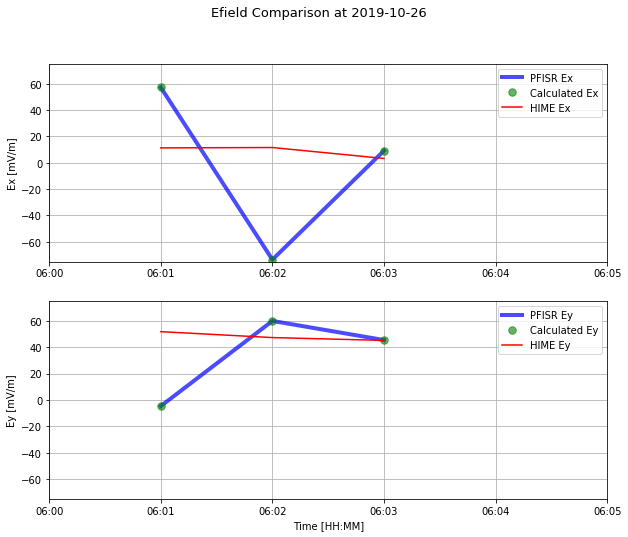

In [21]:
dmin = dt.datetime(2019,10,26,6,0)
dmax = dt.datetime(2019,10,26,6,5)

fig = plt.figure(figsize=(10,8))
a1 = fig.add_subplot(211)
a1.plot(himeTimes, Ex_downsampled[:3,4,4], 'b', linewidth=4., alpha=0.7, label = 'PFISR Ex')
a1.plot(himeTimes, Ex_calculated[:3,4,4], 'g.', linewidth=4., markersize=15, alpha=0.6, label = 'Calculated Ex')
a1.plot(himeTimes, himeEx[:3,4,4], 'r', label = 'HIME Ex')
a1.set_ylim([-75.,75.])
a1.set_xlim([dmin,dmax])
a1.grid()
a1.set_ylabel('Ex [mV/m]')
a1.legend(loc=1)
a1.xaxis.set_major_formatter(myFmt)

a2 = fig.add_subplot(212)
a2.plot(himeTimes, Ey_downsampled[:3,4,4], 'b', linewidth=4., alpha=0.7, label = 'PFISR Ey')
a2.plot(himeTimes, Ey_calculated[:3,4,4], 'g.', linewidth=4., markersize=15, alpha=0.6, label = 'Calculated Ey')
a2.plot(himeTimes, himeEy[:3,4,4], 'r', label = 'HIME Ey')
a2.set_ylim([-75.,75.])
a2.set_xlim([dmin,dmax])
a2.grid()
a2.set_ylabel('Ey [mV/m]')
a2.set_xlabel('Time [HH:MM]')
a2.legend(loc=1)
a2.xaxis.set_major_formatter(myFmt)
plt.suptitle('Efield Comparison at {0:%Y-%m-%d}'.format(dmin), size=13)
plt.savefig(plotdir+'/point_comparisons_{0:%Y%m%d}'.format(dmin), bbox_inches='tight',dpi=200)

We urge the users not to be discouraged by the comparisons at this point, since the Examples only have 3 simulation files. Below is the full comparison for the interval between 0600-1100 UT for the same grid point. <img src="./Images/efield_point_comparisons_20191026.png" width=712 height=468 />

If the user set the plotPotentials and savePotentials flags to True, the results can be found in the hime_plots and hime_input directories.

👏👏👏 Congratulations, you have completed the HIME Tutorial! 

## References

[1] Ozturk, D. S., Verkhoglyadova, O., Meng, X., Semeter, J., Varney, R., Reimer, A. (2020), A new framework to incorporate high-latitude input for meso-scale electrodynamics: HIME, Journal of Geophysical Research: Space Physics, doi.org/10.1029/2019JA027562 <br>
[2] Ridley, A. J., Y. Deng, and G. Toth., 2006, The Global Ionosphere-Thermosphere Model (GITM). J. Atmos. Solar-Terrestr. Phys. 68, 839-864. doi:10.1016/j.jastp.2006.01.008 <br>
[3] Weimer, D. R., Improved ionospheric electrodynamic models and application to calculating Joule heating rates,  J. Geophys. Res., 110, A05306, doi:10.1029/2004JA010884, 2005 <br>